<a href="https://colab.research.google.com/github/fdch/dreamsound/blob/main/DreamSound_v_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Get YAMNet

!git clone https://github.com/tensorflow/models.git
%cd models/research/audioset/yamnet

# Download YAMNet data
!curl -O https://storage.googleapis.com/audioset/yamnet.h5

# Download audio for testing
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav


https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/deepdream.ipynb


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import params as yamnet_params
import yamnet as yamnet_model

import tensorflow as tf

import IPython.display as ipd
from IPython.core.display import display

import librosa, librosa.display

# Load Sound and Yamnet model

In [ ]:
wav_file_name = 'speech_whistling2.wav'
waveform, sr =  librosa.load(wav_file_name, offset=1.5)

params = yamnet_params.Params(sample_rate=sr, patch_hop_seconds=0.1)

class_names = yamnet_model.class_names('yamnet_class_map.csv')
yamnet = yamnet_model.yamnet_frames_model(params)
yamnet.load_weights('yamnet.h5')

In [ ]:
yamnet.summary()

Model: "yamnet_frames"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
tf.compat.v1.shape (TFOpLambda) (1,)                 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici ()                   0           tf.compat.v1.shape[0][0]         
__________________________________________________________________________________________________
tf.math.maximum_1 (TFOpLambda)  ()                   0           tf.__operators__.getitem[0][0]   
______________________________________________________________________________________

In [ ]:
def combine_spectra(x, y,
                    win_length = 2048,
                    hop_length = 128,
                    mul = 0.01,
                    ):
    # take short time fourier transform
    X = tf.signal.stft(x, win_length, hop_length,pad_end=True)
    Y = tf.signal.stft(y * mul, win_length, hop_length,pad_end=True)
    # take magnitude
    Yabs = tf.math.abs(Y) ** 2
    # get rid of tiny values
    Yabs *=  0.5 * ( tf.math.sign(Yabs - 0.1) + 1 )
    # multiply the magnitude with the complex pair
    Yfilt = tf.dtypes.complex( Yabs * tf.math.real(Y), Yabs * tf.math.imag(Y) )
    # combine complex values and take inverse fourier
    return tf.signal.inverse_stft( X + Yfilt, win_length, hop_length)

In [ ]:
def add_min_length(x,y):
    if x.shape[0] < y.shape[0] : y = y[:x.shape[0]]
    if y.shape[0] < x.shape[0] : x = x[:y.shape[0]]
    return x + y

In [ ]:
def dream_big(waveform, model, layername, 
              ot=1, 
              steps=1, 
              step_size=0.001):

    wavetensor =  tf.convert_to_tensor(waveform)

    # Maximize the activations of these layers

    layers = model.get_layer(layername).output
    
    # Create the feature extraction model

    dream_model = tf.keras.Model(inputs=model.input, outputs=layers)
    
    loss = tf.constant(0.0)

    for i in tf.range(steps):
        with tf.GradientTape() as tape:

            # This needs gradients relative to `img`
            # `GradientTape` only watches `tf.Variable`s by default
            tape.watch(wavetensor)
            loss = calc_loss(wavetensor, dream_model, maxloss=True)

        gradients = tape.gradient(loss, wavetensor)

        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        if ot == 0:
            # combine spectra
            wavetensor = combine_spectra(wavetensor, gradients, mul=step_size)
        elif ot == 1:
            # default
            # In gradient ascent, the "loss" is maximized so that 
            # the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients
            wavetensor += gradients * step_size
        elif ot == 2:
            # combine spectra, flipped
            wavetensor = combine_spectra(gradients, wavetensor, mul=step_size)
        else:
            # return gradients only
            wavetensor = gradients

    return wavetensor

In [ ]:
def calc_loss(img, model, maxloss=True, maxframe=False):
  
  # Pass forward the image through the model to retrieve the activations.
  layer_activations = model(img)

  if len(layer_activations) == 1:
    layer_activations = [layer_activations]
  
  if maxloss:
      # dado el maximo, intentar maximizar la suma de todo
      reduced = tf.reduce_mean(layer_activations, axis=0)
      argmax = tf.argmax(reduced) 
      if maxframe:
          frame_argmax = tf.argmax(layer_activations[:,argmax]) 
          loss = layer_activations[frame_argmax, argmax]
      else:
          loss =  tf.reduce_sum(layer_activations[:,argmax])
  else:
      losses = [ tf.math.reduce_mean(act) for act in layer_activations ]
      loss = tf.math.reduce_sum(losses)
  
  return loss

In [ ]:
def plot_and_listen(s, label=''):
    
    fix, ax = plt.subplots(nrows=2,ncols=1,figsize=(12,12), sharex=False)
    
    ax[0].set_title(label + ' Waveform')
    ax[1].set_title(label + ' Spectrogram')
    
    librosa.display.waveplot(s, 
                             ax=ax[0], 
                             x_axis='frames')
    
    librosa.display.specshow(librosa.power_to_db(np.abs(librosa.stft(s))**2), 
                             ax=ax[1], 
                             x_axis='frames', 
                             y_axis='log')
    display(ipd.Audio(s,rate=sr))

## Listen to the original file

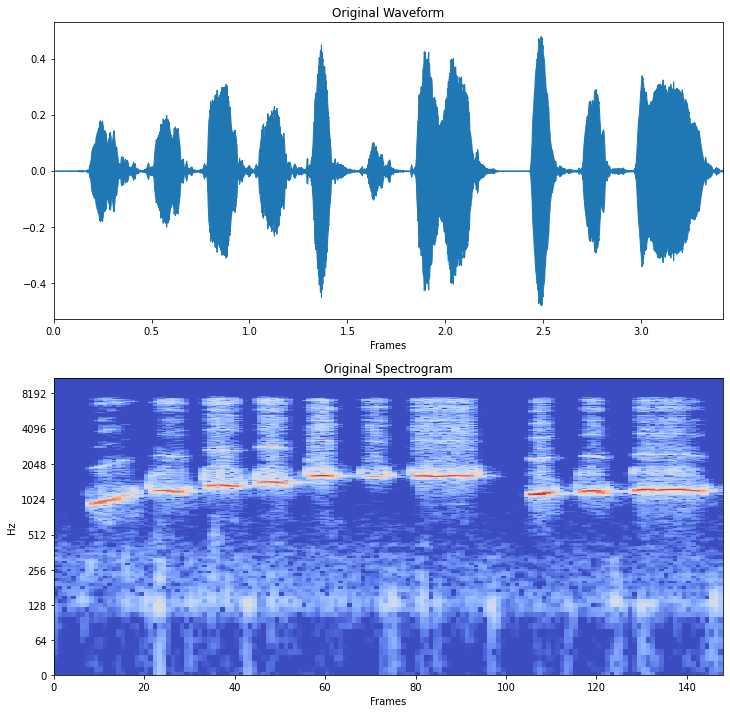

In [ ]:
plot_and_listen(waveform, label='Original')

## 1-step, default output



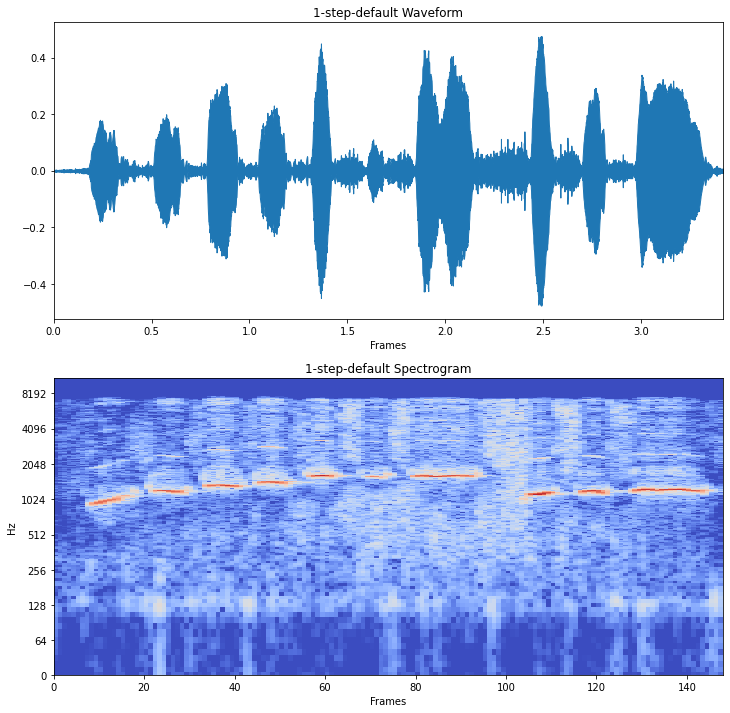

In [ ]:
plot_and_listen(dream_big(waveform, yamnet, yamnet.layers[-1].name, step_size=0.01).numpy(), label="1-step-default")

## 1 step, combine spectra

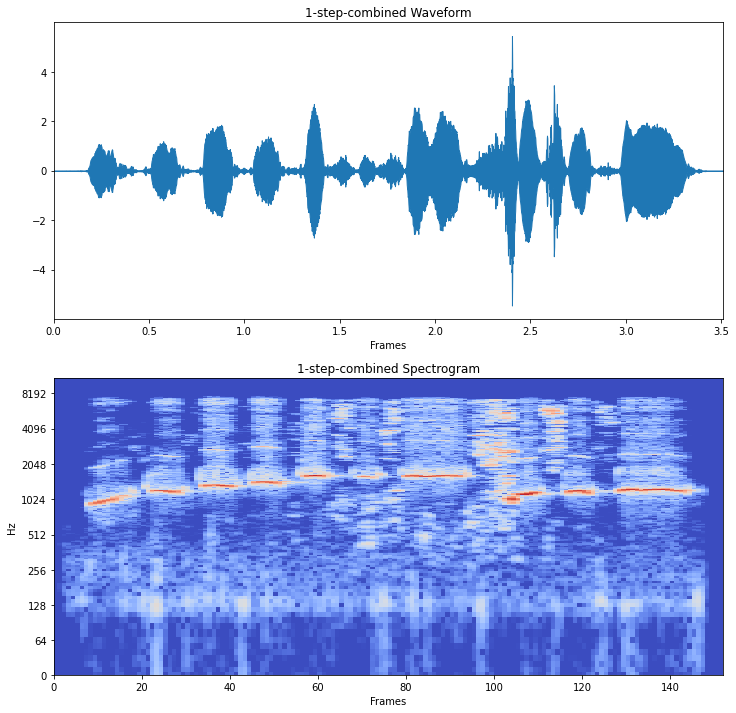

In [ ]:
plot_and_listen(dream_big(waveform, yamnet, yamnet.layers[-1].name,
                         ot=0,
                         step_size=0.01).numpy(), 
                label="1-step-combined")

## 1 step, combine spectra filtering gradients

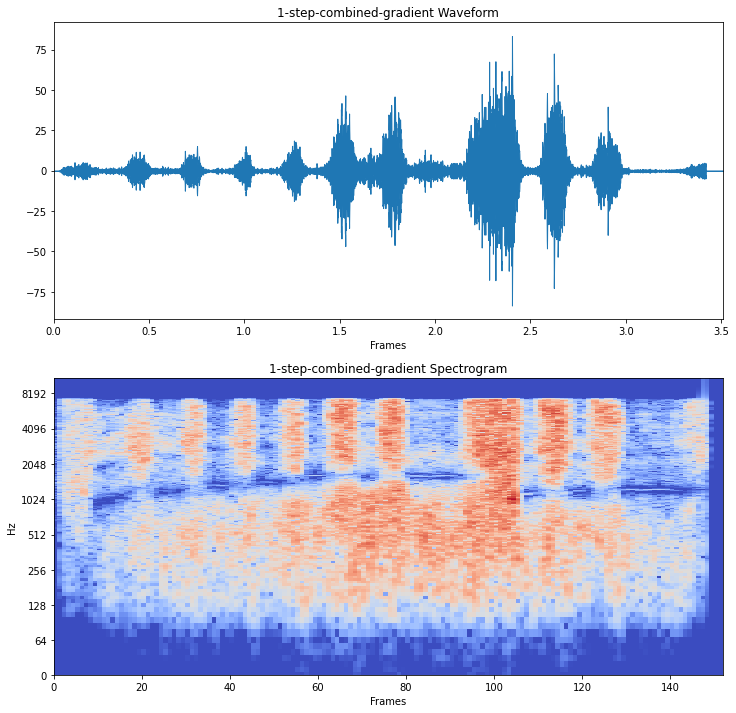

In [ ]:
plot_and_listen(dream_big(waveform, yamnet, yamnet.layers[-1].name,
                         ot=2,
                         step_size=0.01).numpy(), 
                label="1-step-combined-gradient")

## Make iterative steps

In [ ]:
def dream_big_steps(waveform, model, layername, ot=0, steps=100, step_size=0.01):
  
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps
    waveform = dream_big(waveform,model,layername,ot=ot,steps=steps,step_size=step_size)
    
  return waveform

## last layer, 10 steps, gradients only

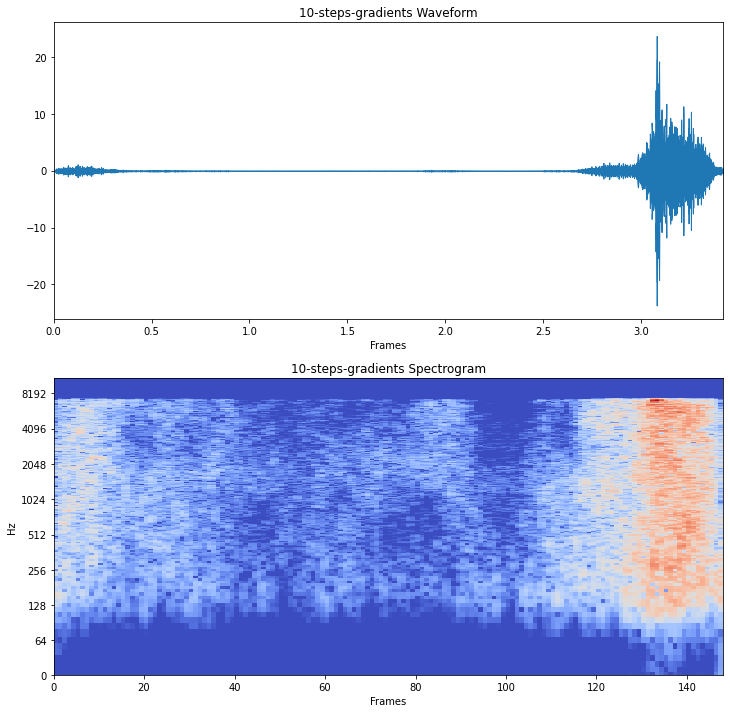

In [ ]:
plot_and_listen(dream_big_steps(waveform, yamnet, yamnet.layers[-1].name,
                                steps=10, 
                                step_size=0.0001, 
                                ot=-1
                                ).numpy(),
                label="10-steps-gradients")

## last layer, 10 steps, combine spectra filtering gradients

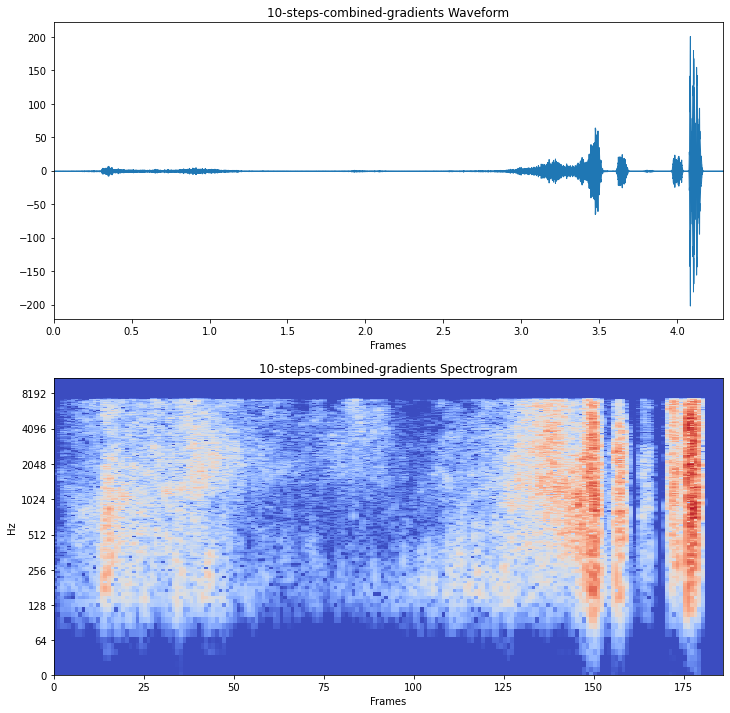

In [ ]:
plot_and_listen(dream_big_steps(waveform, yamnet, yamnet.layers[-1].name,
                                steps=10, 
                                step_size=0.0001, 
                                ot=2
                                ).numpy(),
                label="10-steps-combined-gradients")

## Get last three layers with 20 steps, add everything together *output gradients only

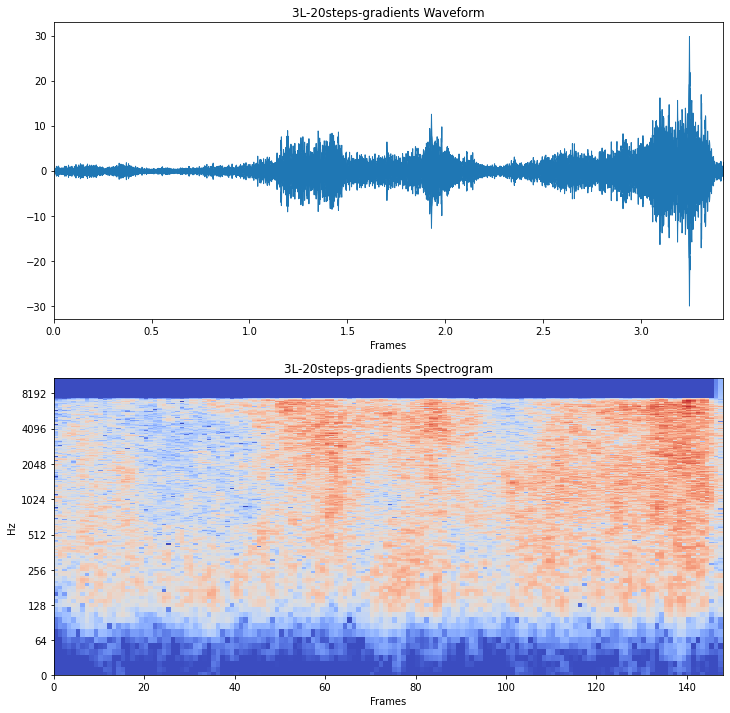

In [ ]:
plot_and_listen(
    np.sum(
        np.concatenate(
            [
             [
              dream_big_steps(waveform, yamnet, layer.name, 
                              steps=20,         # 20 steps
                              step_size=0.001,  # step size
                              ot=-1             # gradients only
                              ).numpy()
              for layer in yamnet.layers[-3:]   # last three layers
              ]
            ]
        ), axis=0 
    ), # sum all elements together in concatenated arrays
    label="3L-20steps-gradients"
)

## last 3 layers, 100 steps, gradients only

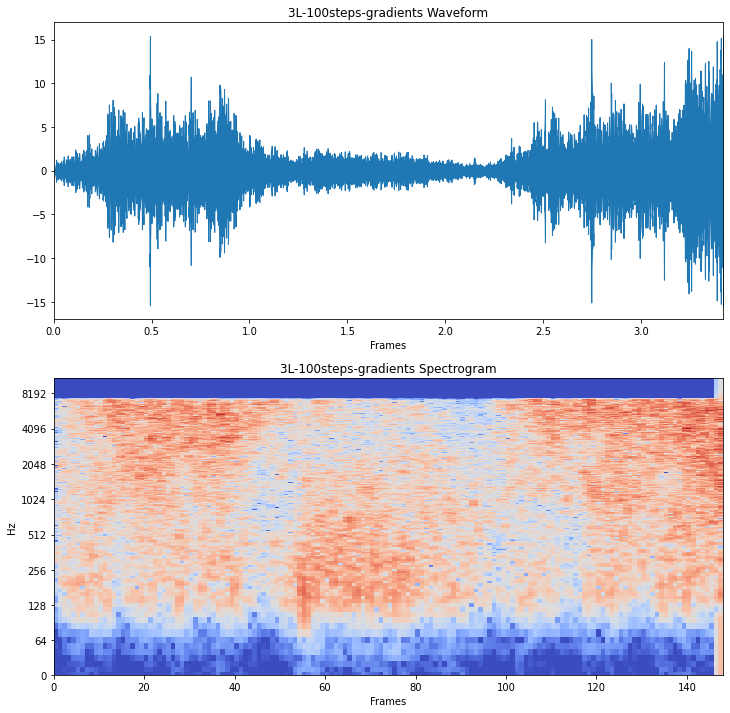

In [ ]:
plot_and_listen(
    np.sum(
        np.concatenate(
            [
             [
              dream_big_steps(waveform, yamnet, layer.name, 
                              steps=100,         # 20 steps
                              step_size=0.0001,  # step size
                              ot=-1              # gradients only
                              ).numpy()
              for layer in yamnet.layers[-3:]   # last three layers
              ]
            ]
        ), axis=0 
    ), # sum all elements together in concatenated arrays
    label="3L-100steps-gradients"
)

## last 3 layers, 25 steps, default

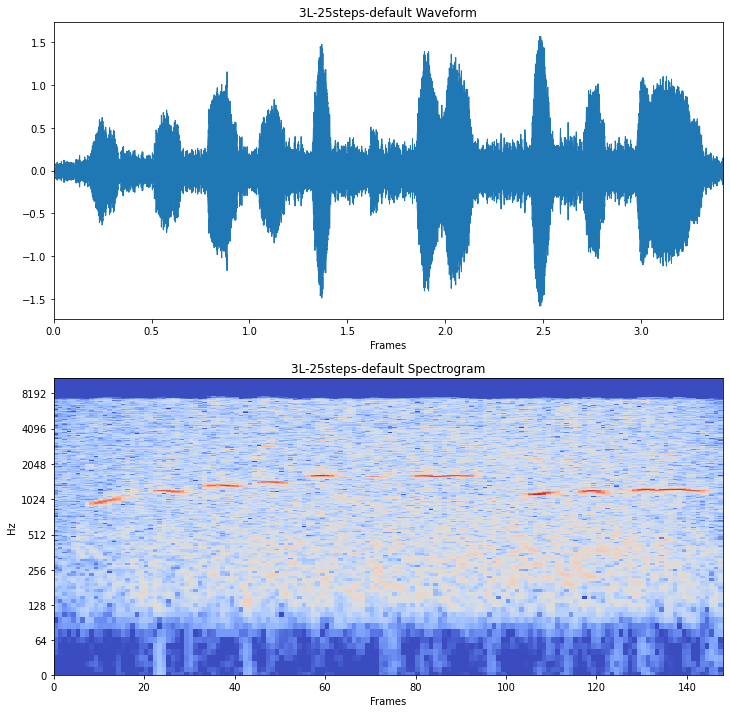

In [ ]:
plot_and_listen(
    np.sum(
        np.concatenate(
            [
             [
              dream_big_steps(waveform, yamnet, layer.name, 
                              steps=25,
                              step_size=0.01,
                              ot=1
                              ).numpy()
              for layer in yamnet.layers[-3:]   # last three layers
              ]
            ]
        ), axis=0 
    ), # sum all elements together in concatenated arrays
    label="3L-25steps-default"
)



---



In [ ]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

In [ ]:
  def tiled_gradients(img, model, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [ ]:
def run_deep_dream_with_octaves(img, model, steps_per_octave=10, step_size=0.01, octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)

  initial_shape = tf.shape(img)
  img = tf.reshape(img, initial_shape)

  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape), tf.float32) * (octave_scale**octave)
    img = tf.reshape(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = tiled_gradients(img, model)
      img = img + gradients*step_size

  return img

In [ ]:
img = run_deep_dream_with_octaves(waveform, yamnet, step_size=0.01)

fix, ax = plt.subplots(nrows=2,ncols=1,figsize=(12,12), sharex=False)

librosa.display.waveplot(snd, ax=ax[0], x_axis='frames', label='Dreamed Waveform')
librosa.display.specshow(dbspec(snd), ax=ax[1], x_axis='frames', y_axis='log', label='Dreamed Sound')
ipd.Audio(snd,rate=sr)

InvalidArgumentError: ignored